In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

from lib import *

# Sample data structure (replace this with your actual data loading process)
fetch_cols = ['pickup_datetime', 'total_amount']

year = 2023
taxi_type = GREEN
sql = text(f"""
    {selFrom(fetch_cols, year, taxi_type)}
    where (strftime('%Y', pickup_datetime))='{year}'
""")

df = getDF(sql)
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

# Extract the target variable
total_amount = df['total_amount'].values

scaler = MinMaxScaler(feature_range=(0, 1))
total_amount_scaled = scaler.fit_transform(total_amount.reshape(-1, 1))

# Define the time step as 168 hours (1 week)
time_step = 168

# Create sequences and labels
X = []
y = []

for i in range(time_step, len(total_amount_scaled)):
    X.append(total_amount_scaled[i - time_step:i, 0])  # Past 168 hours (1 week) of data
    y.append(total_amount_scaled[i, 0])  # The next data point

# Convert to numpy arrays and reshape for LSTM input
X, y = np.array(X), np.array(y)

# Reshape X to be [samples, time steps, features] as expected by LSTM
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, epochs=20, batch_size=32)

# Predict on the training data
train_predictions = model.predict(X)

# Inverse transform the predictions to get them back to the original scale
train_predictions = scaler.inverse_transform(train_predictions)
y_actual = scaler.inverse_transform(y.reshape(-1, 1))


Epoch 1/20
 1092/23807 ━━━━━━━━━━━━━━━━━━━━ 20:44 55ms/step - loss: 0.0212

In [ ]:
# efficiency for 10 epochs and batchsize of 64

from sklearn.metrics import r2_score

# Calculate R-squared
r_squared = r2_score(y_actual, train_predictions)
efficiency = r_squared * 100  # Convert to percentage

print(f"R-squared: {r_squared:.2f}")
print(f"Percentage Efficiency (R-squared as %): {efficiency:.2f}%")


R-squared: 0.03
Percentage Efficiency (R-squared as %): 2.88%


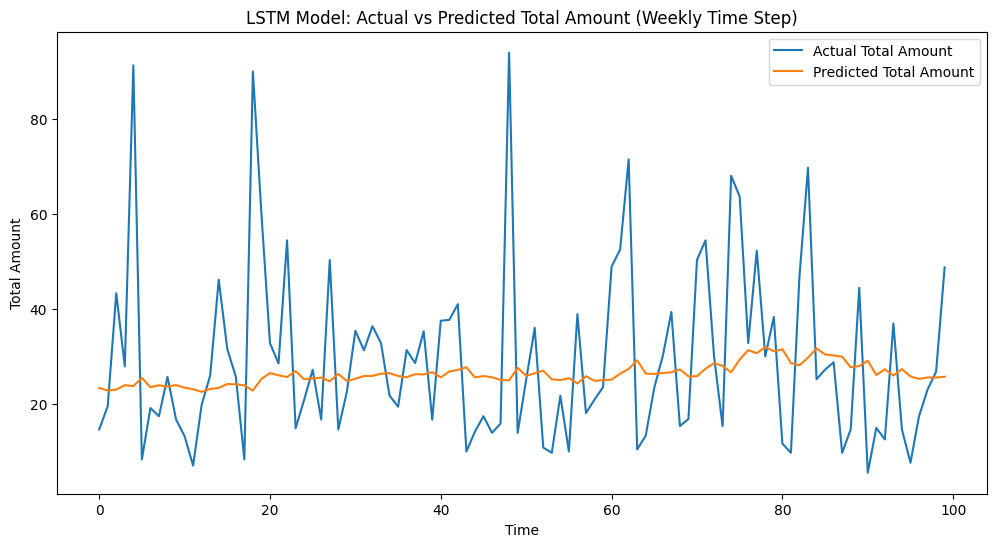

In [ ]:
# plot for 10 epochs and batchsize of 64

plt.figure(figsize=(12, 6))
plt.plot(y_actual[:100], label='Actual Total Amount')
plt.plot(train_predictions[:100], label='Predicted Total Amount')
plt.xlabel('Time')
plt.ylabel('Total Amount')
plt.title('LSTM Model: Actual vs Predicted Total Amount (Weekly Time Step)')
plt.legend()
plt.show()


In [ ]:
# forecast future values - test later

# # Start with the last 'time_step' values from the dataset
# future_input = total_amount_scaled[-time_step:]
# future_predictions = []

# for _ in range(4 * 168):  # Forecasting for the next 4 weeks (4 * 168 hours)
#     future_input_reshaped = future_input.reshape((1, time_step, 1))
#     next_step = model.predict(future_input_reshaped)[0, 0]
#     future_predictions.append(next_step)
    
#     # Update the input sequence for the next prediction
#     future_input = np.append(future_input[1:], next_step)

# # Inverse transform to original scale
# future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# # Plot the forecasted future values
# plt.figure(figsize=(10, 6))
# plt.plot(range(len(total_amount)), total_amount, label='Historical Data')
# plt.plot(range(len(total_amount), len(total_amount) + 4 * 168), future_predictions, label='Forecasted Total Amount', color='orange')
# plt.xlabel('Time')
# plt.ylabel('Total Amount')
# plt.title('LSTM Forecast for Total Amount (Weekly Time Step)')
# plt.legend()
# plt.show()
